Two 5-dimensional Unimodal Gaussian Classes.
100 batches of 1900 instances



METHOD: Static lp as classifier
Execution time:  11.796634687007915
Average MCC:  0.3763748219054415
Average error: 30.905799999999985
Average macro-F1: 0.6695757451888088
Average micro-F1: 0.6894
Acurácia Média:  69.09420000000001
Desvio Padrão:  21.224477481436377
Variância:  450.47844435999986


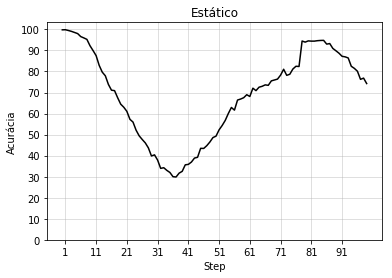

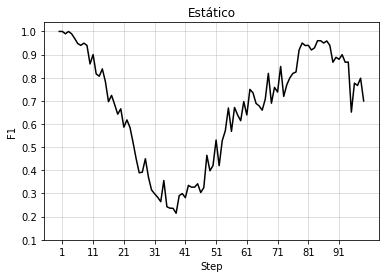




METHOD: Sliding lp as classifier
Execution time:  6.401312423548482
Average MCC:  0.3851818535828147
Average error: 31.174599999999998
Average macro-F1: 0.5974214205965522
Average micro-F1: 0.6953999999999999
Acurácia Média:  68.8254
Desvio Padrão:  21.903270459910775
Variância:  479.75325684


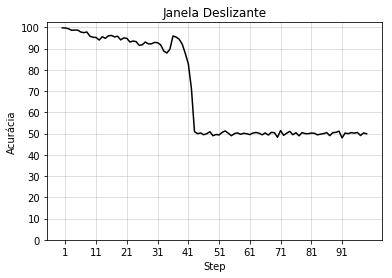

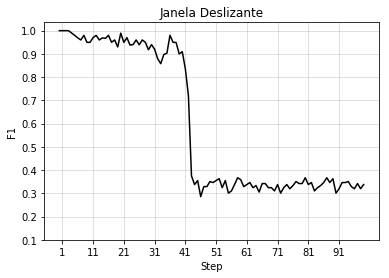




METHOD: Incremental lp as classifier
Execution time:  445.76927837853896
Average MCC:  0.24531300424045482
Average error: 38.886799999999994
Average macro-F1: 0.5072401537589366
Average micro-F1: 0.6115999999999999
Acurácia Média:  61.113200000000006
Desvio Padrão:  17.471011354812866
Variância:  305.2362377600001


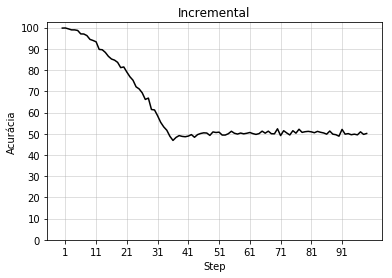

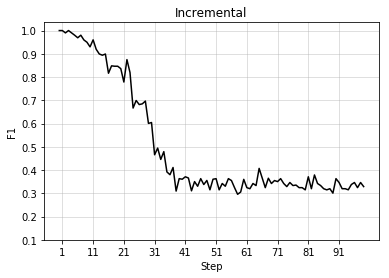




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  25.70926947727304
Average MCC:  0.46128236396792033
Average error: 27.1798
Average macro-F1: 0.6489707260213455
Average micro-F1: 0.7319999999999999
Acurácia Média:  72.8202
Desvio Padrão:  22.286574567662925
Variância:  496.6914059599999


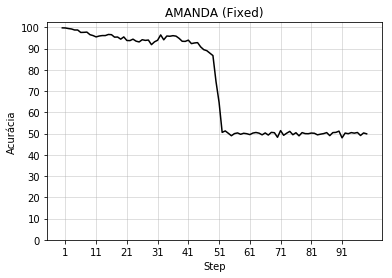

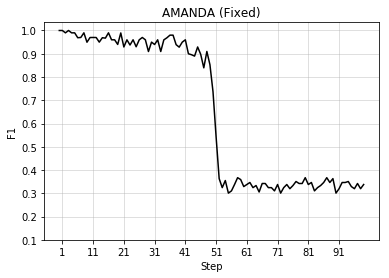




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.40 | Std keeping percentage=0.16
Execution time:  25.998190200334477
Average MCC:  0.4723982504233348
Average error: 26.9563
Average macro-F1: 0.6568094138886391
Average micro-F1: 0.7343999999999999
Acurácia Média:  73.0437
Desvio Padrão:  21.369986366631117
Variância:  456.67631730999983


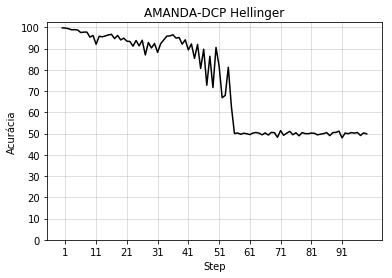

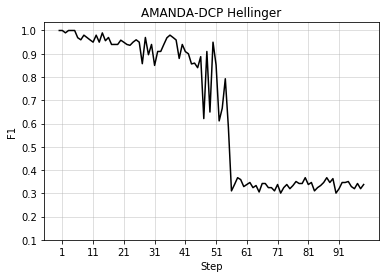




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.19 | Std keeping percentage=0.01
Execution time:  24.510603298693468
Average MCC:  0.834143961232134
Average error: 8.748500000000021
Average macro-F1: 0.9137239988842552
Average micro-F1: 0.9147999999999997
Acurácia Média:  91.25149999999998
Desvio Padrão:  6.617799086554382
Variância:  43.795264750000015


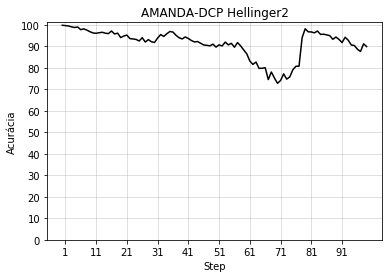

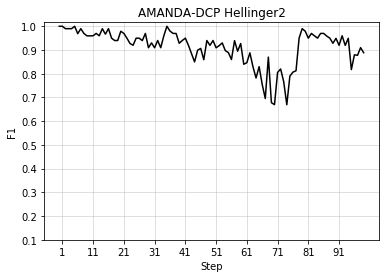




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.10 | Std keeping percentage=0.00
Execution time:  23.897112313635603
Average MCC:  0.8264264790450734
Average error: 8.849700000000013
Average macro-F1: 0.9100711070137808
Average micro-F1: 0.9112000000000002
Acurácia Média:  91.15029999999999
Desvio Padrão:  6.583322634506074
Variância:  43.34013691


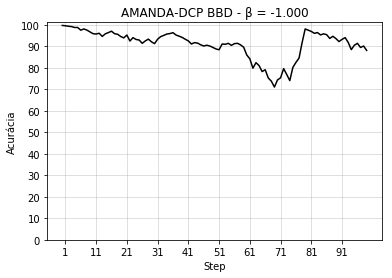

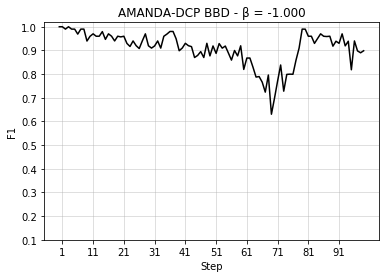

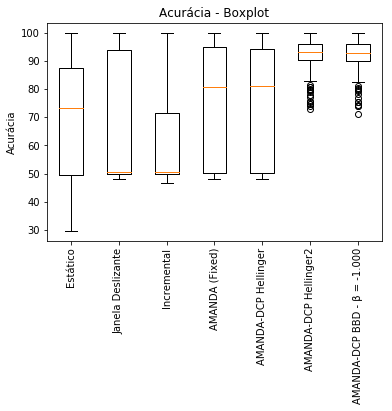

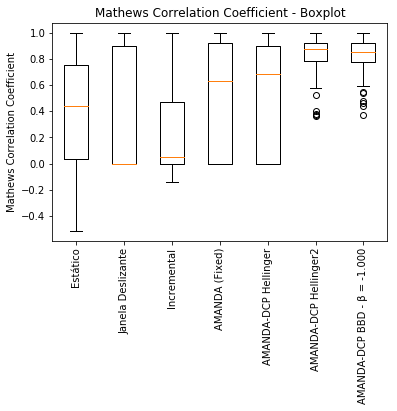

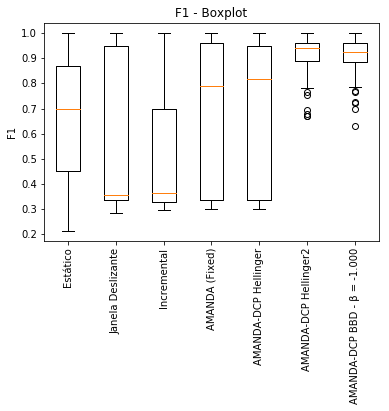

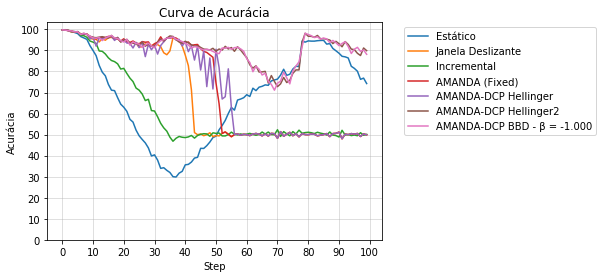

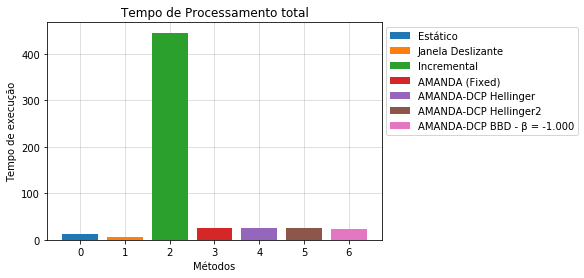

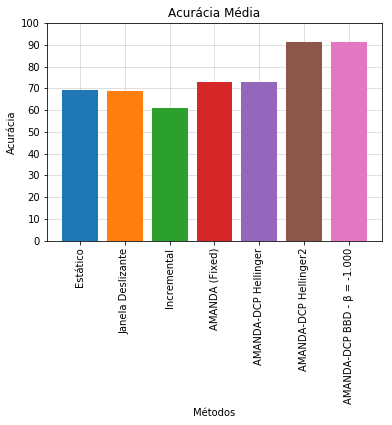

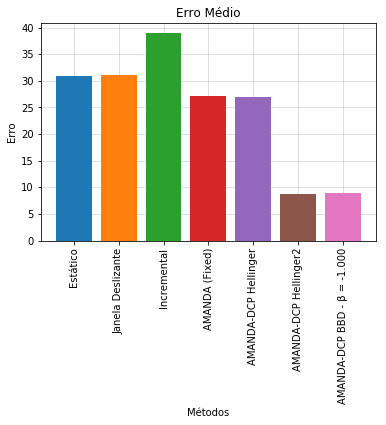

Pos 6 - Redução do Erro (Janela Deslizante):-0.38903410127045823
Pos 7 - Redução do Erro (Incremental):-11.550897180950075
Pos 4 - Redução do Erro (AMANDA (Fixed)):5.39263787698531
Pos 3 - Redução do Erro (AMANDA-DCP Hellinger):5.716109311635399
Pos 1 - Redução do Erro (AMANDA-DCP Hellinger2):32.0682488544624
Pos 2 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):31.92178214669244


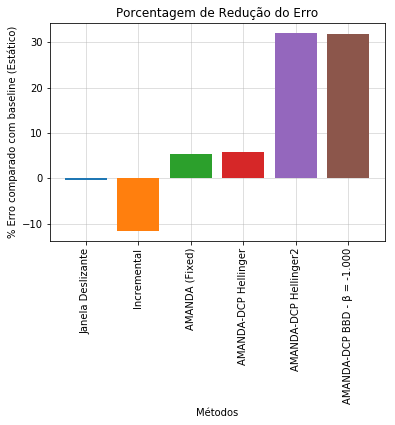

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadUG_2C_5D(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 10, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 10, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 10, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 10, 0.6, "kde", sslClassifier)

   # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 12, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [7, 7, 7, 7]
    betas = [-1]
    bestK = [7]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
    # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 8, None, "kde", sslClassifier, 'HDDDM')    
    
    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 11)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'UG_2C_5D', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()